**Group 4: Subreddit Recommendation with Graph Analysis**

Krishnan Ananth-A0218894M

Mak Chung Yin - A0218938N

Ken Cheah – A0218906Y

Liu Siqing - A0127160R

Tommy Kangdra - A0218866N



# 0. Function

In [2]:
def get_nodes_from_partition(G, partition):
    # Initialize an empty list for nodes to be returned
    nodes = []
    # Iterate over each node in the graph G
    for n in G.nodes():
        # Check that the node belongs to the particular partition
        if G.nodes[n]['bipartite'] == partition:
            # If so, append it to the list of nodes
            nodes.append(n)
    return nodes

In [3]:
def shared_partition_nodes(G, subreddit_list, node2):
    # Check that the nodes belong to the same partition
    # assert G.nodes[node1]['bipartite'] == G.nodes[node2]['bipartite']

    # Get neighbors of node 1: nbrs1
    nbrs1 = subreddit_list
    # Get neighbors of node 2: nbrs2
    nbrs2 = list(G.neighbors(node2))

    # Compute the overlap using set intersections
    overlap = set(nbrs1).intersection(nbrs2)
    union = set(nbrs1).union(nbrs2)
    
    return overlap, len(union)

In [4]:
def user_similarity_jacard(G, subreddit_list, user2, len_proj_nodes):
    # Check that the nodes belong to the 'users' partition
#     assert G.nodes[user1]['bipartite'] == 'user'
    assert G.nodes[user2]['bipartite'] == 'user'
    
    
    # Get the set of nodes shared between the two users
    shared_nodes, union_length = shared_partition_nodes(G, subreddit_list, user2)    

    # Return the fraction of nodes in the projects partition
    jacard_value = len(shared_nodes) / union_length

    return jacard_value

In [5]:
# USING JACARD SIMILARITIES METHOD

def most_similar_users_jacard(G, subreddit_list, user_nodes, len_sr_nodes, threshold):
    from collections import defaultdict

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    # user_nodes.remove(user)
    
    # Create the dictionary: similarities
    similarities = defaultdict(list)
#     for n in tqdm(user_nodes):
    for n in user_nodes:
        similarity = user_similarity_jacard(G, subreddit_list, n, len_sr_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = threshold * max(similarities.keys())
    
    # Return list of users that share maximal similarity
    user_list = [user for (val, user_group) in similarities.items() for user in user_group if val >= max_similarity]
    
    return user_list, max_similarity

In [6]:
def most_similar_users_function(G, subreddit_list, user_nodes, len_sr_nodes, threshold):
    from collections import defaultdict

    # Get other nodes from user partition
    user_nodes = set(user_nodes)
    # user_nodes.remove(user)
    
    # Create the dictionary: similarities
    similarities = defaultdict(list)
#     for n in tqdm(user_nodes):
    for n in user_nodes:
        similarity = user_similarity_jacard(G, subreddit_list, n, len_sr_nodes)
        similarities[similarity].append(n)

    # Compute maximum similarity score: max_similarity
    max_similarity = threshold * max(similarities.keys())
    print('threshold', max_similarity)

    user_list = [user for (val, user_group) in similarities.items() for user in user_group if val >= max_similarity]
    user_val = [(user,val) for (val, user_group) in similarities.items() for user in user_group if val >= max_similarity]
    
    users_series = []
    val_series = []
    for i,v in user_val:
        users_series.append(i)
        val_series.append(v)
    df = pd.DataFrame({'user' : users_series, 'value' : val_series})
    df.sort_values('value', ascending = False, inplace = True)
    display(df)
    
    # Return list of users that share maximal similarity
    return df

In [7]:
def recommend_repositories(G, subreddit_list, to_user):
    # Get the set of repositories that from_user has contributed to
    from_repos = subreddit_list
    
    # Get the set of repositories that to_user has contributed to
    all_recommendation = []
    
    
#     for other_user in tqdm(to_user):
    for other_user in to_user:
        to_repos = set(G.neighbors(other_user))
#         print(to_repos)
        all_recommendation += to_repos.difference(from_repos)
        
    
    all_recommendation = pd.Series(all_recommendation)
        
    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return all_recommendation.value_counts()[:10]

In [8]:
### MAIN FUNCTION - ### 


def recommendation_collaborative_jaccard(G, subreddit_list, threshold):
    user_nodes = get_nodes_from_partition(G, 'user')
    len_sr_nodes = len(get_nodes_from_partition(G, 'subreddit'))

    users_similar, max_similarity_value = most_similar_users_jacard(G, 
                                                             subreddit_list, 
                                                             user_nodes, 
                                                             len_sr_nodes, 
                                                             threshold)
    
    result = recommend_repositories(G, subreddit_list, users_similar)
    
    return users_similar, max_similarity_value, result

In [9]:
def recommend_repositories_user(G, subreddit_list, to_user):
    # Get the set of repositories that from_user has contributed to
    from_repos = subreddit_list
    # Get the set of repositories that to_user has contributed to
    all_recommendation = []
#     for other_user in tqdm(to_user):
    for other_user in to_user:
        to_repos = set(G.neighbors(other_user))
#         print(to_repos.difference(from_repos))
        all_recommendation += to_repos.difference(from_repos)
        
    
    all_recommendation = pd.Series(all_recommendation)
        
    # Identify repositories that the from_user is connected to that the to_user is not connected to
    return all_recommendation.value_counts()

# 1. Loading the Data into Graph

In [35]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import networkx as nx

In [36]:
df_user100 = pd.read_csv('./Testing and Validation/v2/v2/all_exc_2k_v2.csv')

In [37]:
from tqdm import tqdm
tqdm.pandas()
df_user100.author = df_user100.author.progress_apply(lambda x: 'us_' + x)
df_user100.subreddit = df_user100.subreddit.progress_apply(lambda x: 'sr_' + x)

100%|█████████████████████████████████████████████████████████████████████| 854187/854187 [00:00<00:00, 1331859.22it/s]


In [38]:
nodes_a = df_user100.author.unique()
nodes_sr = df_user100.subreddit.unique()
print(len(nodes_a), len(nodes_sr))

280981 100


In [39]:
pair_us = []
for i in tqdm(zip(df_user100.author, df_user100.subreddit)):
    pair_us.append(i)
print(len(pair_us))

854187it [00:00, 2087588.83it/s]

854187


In [40]:
# Adding Nodes with the status 
nodes_a_tupple = [] 
nodes_sr_tupple = []
for nodes in tqdm(nodes_a):
    nodes_a_tupple.append((nodes, {'bipartite' : 'user'}))
        
for nodes in tqdm(nodes_sr):
    nodes_sr_tupple.append((nodes, {'bipartite' : 'subreddit'}))

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 99793.10it/s]


In [41]:
import networkx as nx
G = nx.Graph()

G.add_nodes_from(nodes_a_tupple)
G.add_nodes_from(nodes_sr_tupple)
G.add_edges_from(pair_us)

# 2. Evaluation on Masked Data

In [42]:
test_df = pd.read_csv('./Testing and Validation/v2/v2/test_2k_unmasked.csv')
answer_df = pd.read_csv('./Testing and Validation/v2/v2/test_2k_mask_answer_v2.csv')

In [43]:
test_df.author = test_df.author.progress_apply(lambda x: 'us_' + x)
test_df.subreddit = test_df.subreddit.progress_apply(lambda x: 'sr_' + x)
answer_df.author = answer_df.author.progress_apply(lambda x: 'us_' + x)
answer_df.subreddit = answer_df.subreddit.progress_apply(lambda x: 'sr_' + x)

100%|██████████████████████████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 999714.93it/s]


In [44]:
test_df.head(2)

,Unnamed: 0,author_fullname,author,subreddit,subreddit_ranking,t_user_sub_comments,num_of_subreddit
0,0,t2_106bpk58,us_Apc_007,sr_iamatotalpieceofshit,96,5,2
1,1,t2_10aj9l3k,us_Hollow661,sr_Showerthoughts,19,80,3


## 2.1 Specific User Recommendation

In [45]:
subreddit_follow = []
final_score_top1 = []
final_score_top5 = []
final_score_top10 = []
similar_user_n = []

In [68]:
answer_df[answer_df.author == 'us_Akshay71']

,Unnamed: 0,author_fullname,author,subreddit,subreddit_ranking,t_user_sub_comments,num_of_subreddit
22,22,t2_11d4m6t0,us_Akshay71,sr_lakers,82,9,2


In [46]:
test_df[test_df.author == 'us_Akshay71']

,Unnamed: 0,author_fullname,author,subreddit,subreddit_ranking,t_user_sub_comments,num_of_subreddit
24,24,t2_11d4m6t0,us_Akshay71,sr_nba,2,5,2


In [74]:
name = 'us_Akshay71'
subreddit = test_df[test_df.author == name].subreddit.values
subreddit_follow.append(len(subreddit))

user_nodes = get_nodes_from_partition(G, 'user')
len_sr_nodes = len(get_nodes_from_partition(G, 'subreddit'))
df = most_similar_users_function(G, subreddit, user_nodes, len_sr_nodes, 0.40)

threshold 0.2


,user,value
0,us_TheWinRock,0.5
7364,us_YouNeedABassPlayer,0.5
7356,us_Tisko,0.5
7357,us_OfficialPaddysPub,0.5
7358,us_sammyh34,0.5
...,...,...
13776,us_youryoureyouier,0.2
13775,us_Kyber99,0.2
13774,us_stashtv,0.2
13773,us_Toolshed462,0.2


In [81]:
result = recommend_repositories_user(G, subreddit, df.user.values)
result[:10]

sr_AskReddit         2723
sr_torontoraptors    2516
sr_lakers            2186
sr_nfl               2083
sr_soccer            1995
sr_politics          1656
sr_hockey            1322
sr_baseball          1293
sr_SquaredCircle      964
sr_hiphopheads        803
dtype: int64

In [66]:
sr_answer

'sr_lakers'

# 2.2. Check Model Performance from 2000 users

In [ ]:
test_author = test_df.author.unique()
subreddit_follow = []
final_score_top1 = []
final_score_top5 = []
final_score_top10 = []
similar_user_n = []

top1_res = []
top5_res = []
top10_res = []

for val in [0.2, 0.4, 0.6, 0.8]:
    for name in tqdm(test_author):
    #     print(name)
        subreddit = test_df[test_df.author == name].subreddit.values
        subreddit_follow.append(len(subreddit))

        users_similar, threshold, sr_recommendation =  recommendation_collaborative_jaccard(G, subreddit, val)

        top1 = sr_recommendation.index[0] if len(sr_recommendation) != 0 else '0'
        top5 = sr_recommendation.index[:5] if len(sr_recommendation) != 0 else ['0']
        top10 = sr_recommendation.index if len(sr_recommendation) != 0 else ['0']
    #     print(top1)

        sr_answer = answer_df[answer_df.author == name].subreddit.iloc[0]
    #     print(sr_answer)

        top1_score = (sr_answer == top1)
        top5_score = (sr_answer in top5)
        top10_score = (sr_answer in top10)

        final_score_top1.append(top1_score)
        final_score_top5.append(top5_score)
        final_score_top10.append(top10_score)
        similar_user_n.append(np.sum(np.array(len(users_similar))))
        
    top1_res.append(np.sum(final_score_top1)/2000 * 100)
    top5_res.append(np.sum(final_score_top5)/2000 * 100)
    top10_res.append(np.sum(final_score_top10)/2000 * 100)

In [ ]:
df_result2 = pd.DataFrame({'top1' : top1_res,
                          'top5' : top5_res,
                          'top10' : top10_res})
df_result2.to_csv('result_jaccard.csv')

# 3.0 Result

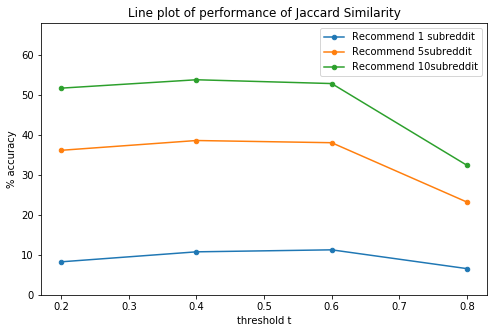

In [26]:
plt.figure(figsize = (8,5))
plt.title('Line plot of performance of Jaccard Similarity')
plt.plot([0.2, 0.4, 0.6, 0.8], df_result2.top1, marker = '.', markersize = 9, label = 'Recommend 1 subreddit')
plt.plot([0.2, 0.4, 0.6, 0.8], df_result2.top5, marker = '.', markersize = 9, label = 'Recommend 5subreddit')
plt.plot([0.2, 0.4, 0.6, 0.8], df_result2.top10, marker = '.', markersize = 9, label = 'Recommend 10subreddit')
plt.xlabel('threshold t')
plt.ylabel('% accuracy')
plt.ylim(0,68)
plt.legend()
plt.show()
